In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from files.Simulation import Simulation
from files.Source import Source
from files.Observer import Observer

## Parameters

In [42]:
nr_particles = 10**1
nr_steps = 1*10**5
source_pos = np.array([0.0, 0.0, 0.0], dtype=np.float32)
delta_rho_div_phi = 1.0 # (delta_r_rho / delta_r_phi)
gyro_radius = 10**11 # [m]
observer_substeps = np.array([True, True, True]) #np.array([True, True, True])
mean_free_path = np.array([2.13*10**12/2.0, 2.13*10**12/2.0, 2.1078*10**12])  # [m]
observer_spheres = np.array([-1.0]) # np.array([1.0*10**16, 1.0*10**17, 1.0*10**18, 1.0*10**19, 1.0*10**20]) # np.array([-1.0]) is just a time evolution observer

## Simulation setup

In [43]:
sim = Simulation()

source = Source(gyro_radius, mean_free_path, source_pos, nr_particles)
sim.add_source(source)

observer = Observer(observer_substeps)
sim.add_observer(observer)

%time sim.run_simulation(nr_steps)
sim.save_data('data')

start simulation
source
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
init particle [0. 0. 0.]
observer
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
[0. 0. 0.]
CPU times: user 964 ms, sys: 34.8 ms, total: 999 ms
Wall time: 999 ms


In [50]:
class Vizualizer():
    def __init__(self, df):
        print('init vizualizer')
        self.df = df
        
    def get_particle_ids(self):
        return list(map(int, (set(self.df['id']))))
        
    def plot_trajectory(self, x, y, c, particle_ids, n, file_name):
        if isinstance(particle_ids, int):
            # create a list if only one id was passed to particle_ids
            particle_ids = [particle_ids]
        plt.figure(figsize=(4.5,4))
        for particle_id in particle_ids:
            # filter the pandas dataframe for data of the current particle_id
            df_ids = self.df[self.df['id'] == particle_id]
            plt.scatter(df_ids[x][:n], df_ids[y][:n], s = 4, c=df_ids[c][:n], cmap='viridis')
        # plot colorbar next to plot
        cbar = plt.colorbar()
        cbar.set_label(c + ' [m]')
        plt.tight_layout()
        plt.xlabel(x + ' [m]')
        plt.ylabel(y + ' [m]')
        plt.tight_layout()
        if file_name is not None:
            plt.savefig(file_name)
        plt.show()
        
    def plot_trjectory_substeps(self):
        #n = 35
        n = 50
        plt.figure(figsize=(4,4))
        x_0 = self.df['x'].tolist()[0:n:2]
        x_1 = self.df['x'].tolist()[1:n-1:2]
        y_0 = self.df['y'].tolist()[0:n:2]
        y_1 = self.df['y'].tolist()[1:n-1:2]
        x_phi = np.vstack([x_0[:-2],x_1[:-1]])
        y_phi = np.vstack([y_0[:-2],y_1[:-1]])
        x_rho = np.vstack([x_1[:-1],x_0[2:]])
        y_rho = np.vstack([y_1[:-1],y_0[2:]])
        plt.plot([0], [0], 'r', ls='--', label='move in $\phi$')
        plt.plot([0], [0], 'b', ls=':', label='move in $\\rho$')
        plt.plot(x_phi,y_phi, 'r', ls='--')
        plt.plot(x_rho,y_rho, 'b', ls=':')
        plt.scatter(x_0, y_0, c='k', s=15, label='no direction change')
        #plt.scatter(df['x'].tolist()[8], df['y'].tolist()[8], c='r', s=15, label='change in $\phi$')
        #plt.scatter(df['x'].tolist()[28], df['y'].tolist()[28], c='b', s=15, label='change in $\\rho$')
        plt.scatter([df['x'].tolist()[0]], [df['y'].tolist()[0]], c='orange', s=25, label='start')
        plt.plot(df['x'].tolist()[0:n:2], df['y'].tolist()[0:n:2], color='k', label='effective trajectory')
        #plt.scatter(df['x'][:n], df['y'][:n], s= 4)
        #plt.plot(df['x'][:n], df['y'][:n])
        #plt.plot(df['x'][n-1:2*n], df['y'][n-1:2*n], color='k')
        plt.xlabel('x [m]')
        plt.ylabel('y [m]')
        plt.legend()
        plt.axis('square')
        plt.tight_layout()
        #plt.savefig('single_trajectory_detailed.pdf')
        plt.show()

init vizualizer


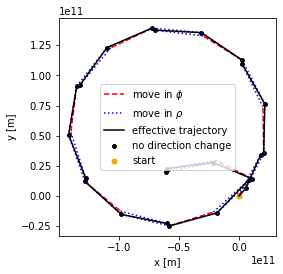

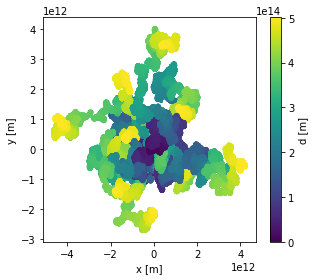

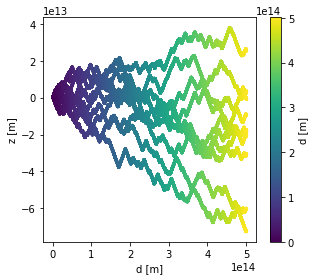

In [51]:
df = pd.read_pickle("data.pkl")
#print(df)
df_time_evolution_observer = df.loc[df['radius'] == -1.0]
vis = Vizualizer(df_time_evolution_observer)
particle_ids = vis.get_particle_ids()
vis.plot_trjectory_substeps()
vis.plot_trajectory('x', 'y', 'd', particle_ids[:], -1, None)
vis.plot_trajectory('d', 'z', 'd', particle_ids[:], -1, None)